# Tree Species Point Cloud Data Visualization

This notebook covers the essential data visualization phase of the tree species classification project.

## Project Structure:
1. Dataset download ✓ DONE
2. Train/test split ✓ DONE  
3. Data visualization ← Current phase
4. Feature extraction (LBP + FPFH) ← Next phase
5. Classification (RBF SVM) ← Final phase

## Current Task: 
Explore and visualize point cloud data to understand the dataset before feature extraction.

## 1. Dataset Structure Analysis

First, let's examine the folder structure and understand what we have.

In [26]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import os

# Set up matplotlib for better plotting
plt.style.use('default')
%matplotlib inline

print("Libraries imported successfully")
print("Current working directory:", os.getcwd())

Libraries imported successfully
Current working directory: /Users/ayoub/work/prjt/notebooks


In [27]:
# Examine dataset folder structure
base_path = Path("..")  # Go up one level from notebooks folder

print("Project Structure:")
print("===================")

# Check if train and test folders exist
train_path = base_path / "train"
test_path = base_path / "test"

if train_path.exists() and test_path.exists():
    print("✓ Train and test folders found")
    
    # Count species in train folder
    train_species = [f.name for f in train_path.iterdir() if f.is_dir()]
    test_species = [f.name for f in test_path.iterdir() if f.is_dir()]
    
    print(f"✓ Train species: {len(train_species)}")
    print(f"✓ Test species: {len(test_species)}")
    print(f"✓ Species names: {sorted(train_species)}")
else:
    print("❌ Train/test folders not found. Please check your directory structure.")
    print(f"Looking in: {base_path.absolute()}")

Project Structure:
✓ Train and test folders found
✓ Train species: 7
✓ Test species: 7
✓ Species names: ['Ash', 'Beech', 'Douglas Fir', 'Oak', 'Pine', 'Red Oak', 'Spruce']


## 2. Dataset Statistics

Let's count files and understand the dataset distribution.

In [28]:
# Calculate dataset statistics
def get_dataset_stats():
    """Get statistics for train and test datasets"""
    stats = {}
    
    for split in ['train', 'test']:
        split_path = base_path / split
        split_stats = {}
        
        for species_folder in split_path.iterdir():
            if species_folder.is_dir():
                species = species_folder.name
                files = [f for f in species_folder.iterdir() if f.is_file()]
                
                split_stats[species] = {
                    'count': len(files),
                    'formats': list(set([f.suffix for f in files]))
                }
        
        stats[split] = split_stats
    
    return stats

# Get and display statistics
stats = get_dataset_stats()

print("Dataset Statistics")
print("=" * 60)
print(f"{'Species':<15} {'Train':<8} {'Test':<8} {'Total':<8} {'Formats'}")
print("-" * 60)

total_train = 0
total_test = 0

for species in sorted(stats['train'].keys()):
    train_count = stats['train'][species]['count']
    test_count = stats['test'].get(species, {'count': 0})['count']
    total_count = train_count + test_count
    
    # Get unique formats
    train_formats = set(stats['train'][species]['formats'])
    test_formats = set(stats['test'].get(species, {'formats': []})['formats'])
    all_formats = sorted(train_formats | test_formats)
    formats_str = ', '.join(all_formats)
    
    print(f"{species:<15} {train_count:<8} {test_count:<8} {total_count:<8} {formats_str}")
    total_train += train_count
    total_test += test_count

print("-" * 60)
print(f"{'TOTAL':<15} {total_train:<8} {total_test:<8} {total_train + total_test:<8}")

# Calculate split ratio
test_percentage = (total_test / (total_train + total_test)) * 100
print(f"\nSplit ratio: {100-test_percentage:.1f}% train, {test_percentage:.1f}% test")
print(f"Total files: {total_train + total_test:,}")
print(f"Number of species: {len(stats['train'])}")

Dataset Statistics
Species         Train    Test     Total    Formats
------------------------------------------------------------
Ash             32       7        39       .pts, .xyz
Beech           132      32       164      .pts, .xyz
Douglas Fir     147      36       183      .txt, .xyz
Oak             18       4        22       .txt
Pine            20       5        25       .txt, .xyz
Red Oak         81       19       100      .txt
Spruce          127      31       158      .txt, .xyz
------------------------------------------------------------
TOTAL           557      134      691     

Split ratio: 80.6% train, 19.4% test
Total files: 691
Number of species: 7


## 3. Point Cloud Loading Functions

Simple functions to load point cloud data from different file formats.

In [29]:
def load_point_cloud(file_path):
    """
    Load point cloud from .pts/.xyz/.txt file
    Returns: numpy array of shape (N, 3) with X,Y,Z coordinates
    """
    try:
        data = np.loadtxt(file_path)
        points = data[:, :3]  # Take first 3 columns (X, Y, Z)
        return points
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def get_sample_files(species, split="train", n_files=1):
    """Get sample files for a species"""
    species_path = base_path / split / species
    if species_path.exists():
        files = [f for f in species_path.iterdir() if f.is_file()]
        return files[:n_files]
    return []

# Test loading a sample file
print("Testing point cloud loading...")
sample_species = sorted(stats['train'].keys())[0]  # Get first species
sample_files = get_sample_files(sample_species, "train", 1)

if sample_files:
    sample_file = sample_files[0]
    points = load_point_cloud(sample_file)
    
    if points is not None:
        print(f"✓ Successfully loaded: {sample_file.name}")
        print(f"  Species: {sample_species}")
        print(f"  Points: {len(points):,}")
        print(f"  Shape: {points.shape}")
        print(f"  Data range:")
        print(f"    X: [{points[:, 0].min():.2f}, {points[:, 0].max():.2f}]")
        print(f"    Y: [{points[:, 1].min():.2f}, {points[:, 1].max():.2f}]")
        print(f"    Z: [{points[:, 2].min():.2f}, {points[:, 2].max():.2f}]")
else:
    print("❌ No sample files found")

Testing point cloud loading...
✓ Successfully loaded: 94.pts
  Species: Ash
  Points: 74,760
  Shape: (74760, 3)
  Data range:
    X: [0.06, 7.91]
    Y: [-29.97, -21.48]
    Z: [-2.38, 28.71]


## 4. Basic Point Cloud Visualization

Create 3D plots to visualize individual point clouds.

Downsampled from 74,760 to 10,680 points for visualization


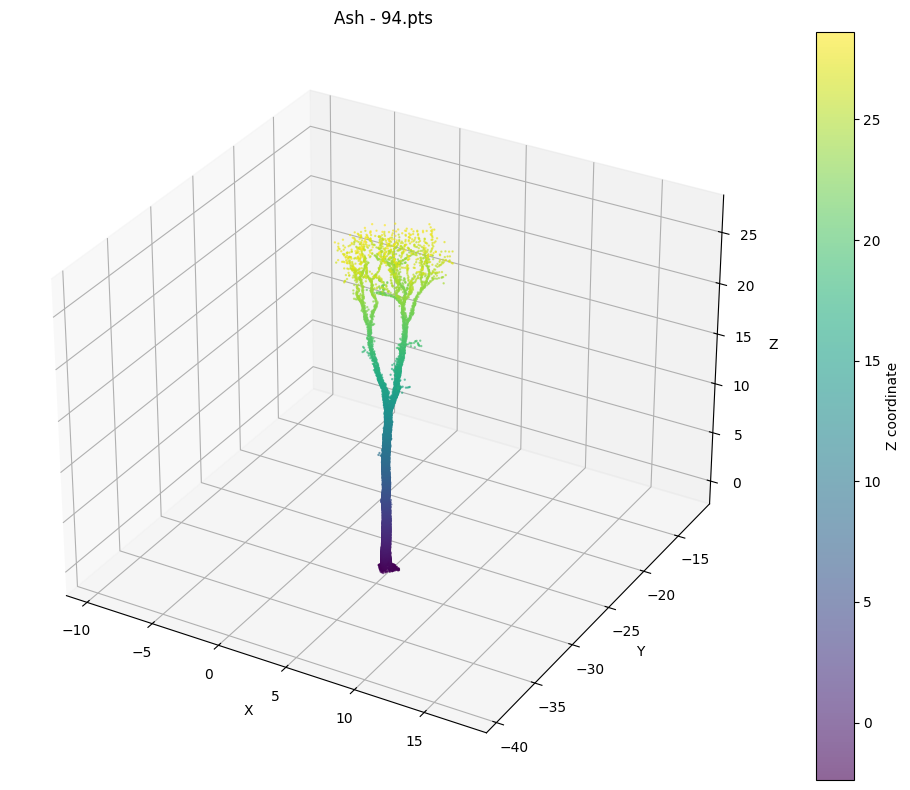

In [30]:
def plot_point_cloud(points, title="Point Cloud", max_points=10000):
    """
    Simple 3D visualization of point cloud
    """
    # Downsample if too many points for better performance
    if len(points) > max_points:
        step = len(points) // max_points
        points_viz = points[::step]
        print(f"Downsampled from {len(points):,} to {len(points_viz):,} points for visualization")
    else:
        points_viz = points
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Color by Z coordinate (height)
    scatter = ax.scatter(points_viz[:, 0], points_viz[:, 1], points_viz[:, 2], 
                        c=points_viz[:, 2], cmap='viridis', s=0.5, alpha=0.6)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y') 
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Z coordinate')
    
    # Make axes equal scale
    max_range = np.array([points_viz[:, 0].max()-points_viz[:, 0].min(),
                         points_viz[:, 1].max()-points_viz[:, 1].min(),
                         points_viz[:, 2].max()-points_viz[:, 2].min()]).max() / 2.0
    mid_x = (points_viz[:, 0].max()+points_viz[:, 0].min()) * 0.5
    mid_y = (points_viz[:, 1].max()+points_viz[:, 1].min()) * 0.5
    mid_z = (points_viz[:, 2].max()+points_viz[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    plt.show()

# Visualize the sample point cloud we loaded earlier
if 'points' in locals() and points is not None:
    plot_point_cloud(points, f"{sample_species} - {sample_file.name}")
else:
    print("No point cloud loaded to visualize")

## 5. Sample Visualization from Each Species

Load and visualize one sample from each tree species to see the differences.

Loading and visualizing samples from each species...

Processing Ash...
  File: 94.pts
  Points: 74,760
Downsampled from 74,760 to 10,680 points for visualization


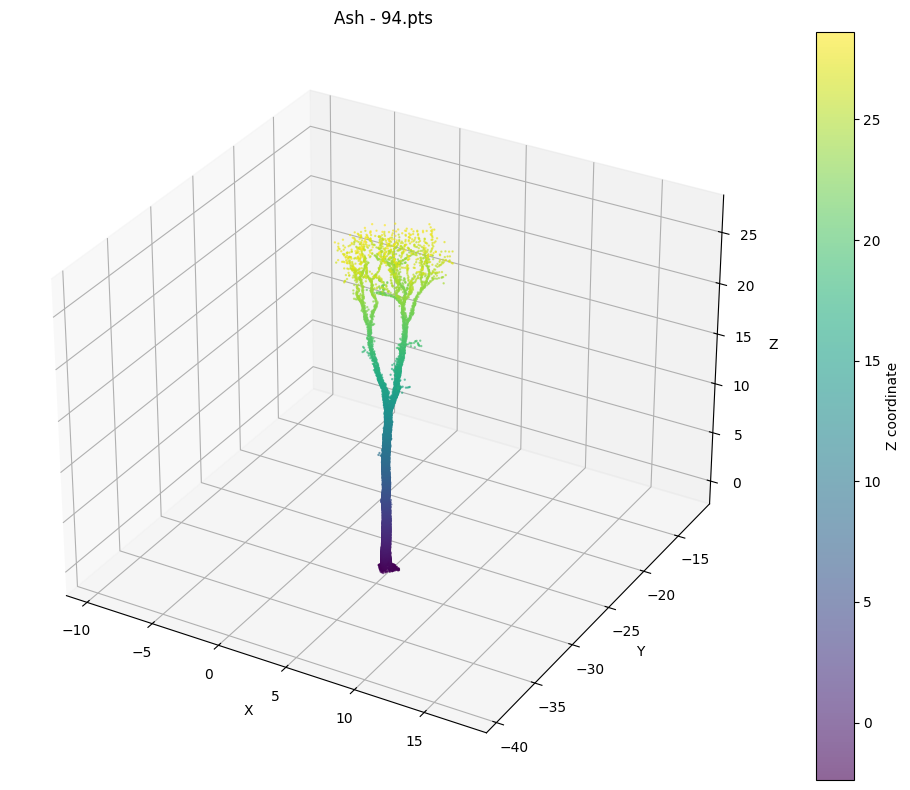


Processing Beech...
  File: 142.pts
  Points: 171,377
Downsampled from 171,377 to 10,081 points for visualization


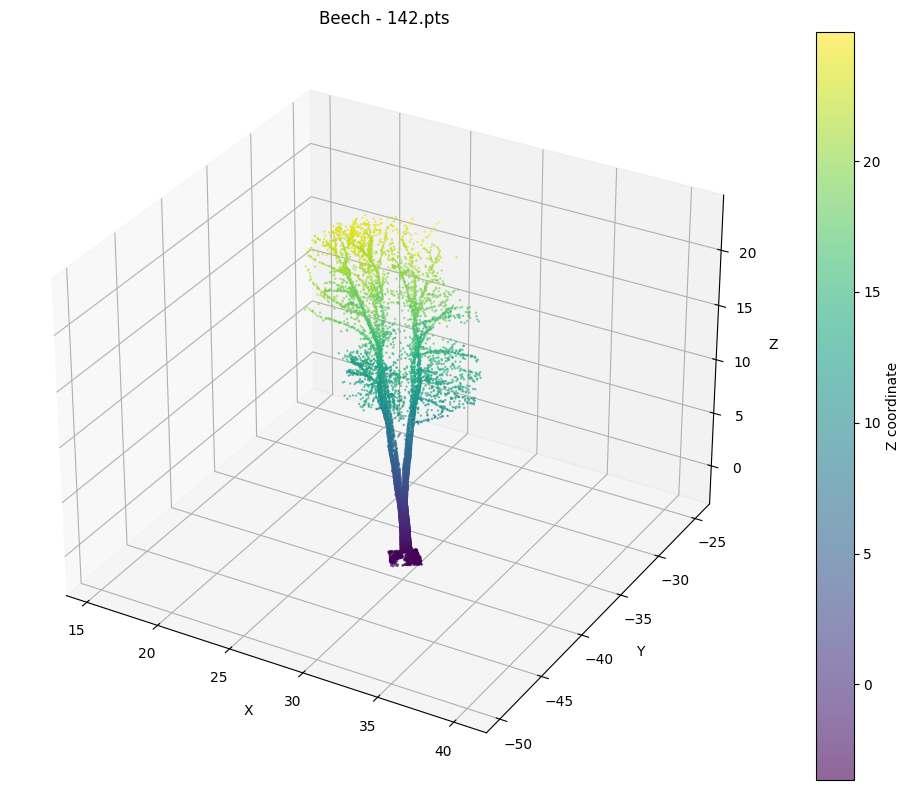


Processing Douglas Fir...
  File: Tree1_Interior.xyz
  Points: 803,163
Downsampled from 803,163 to 10,040 points for visualization


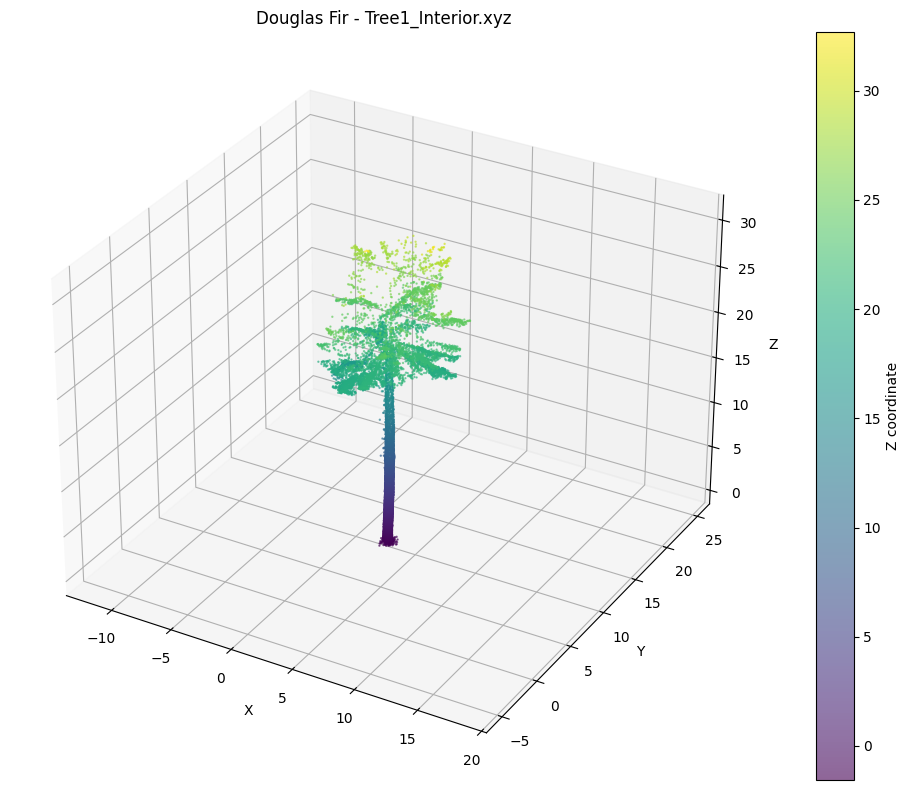


Processing Oak...
  File: 29.txt
  Points: 245,104
Downsampled from 245,104 to 10,213 points for visualization


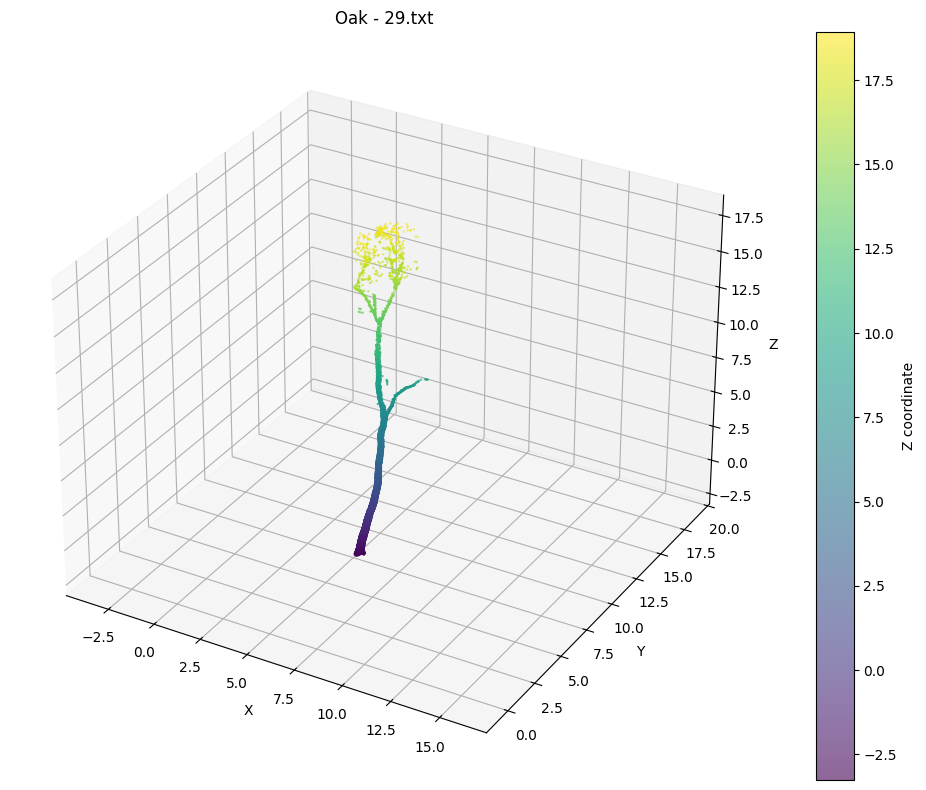


Processing Pine...
  File: Jerome_Ki2_SEW4.xyz
  Points: 270,639
Downsampled from 270,639 to 10,024 points for visualization


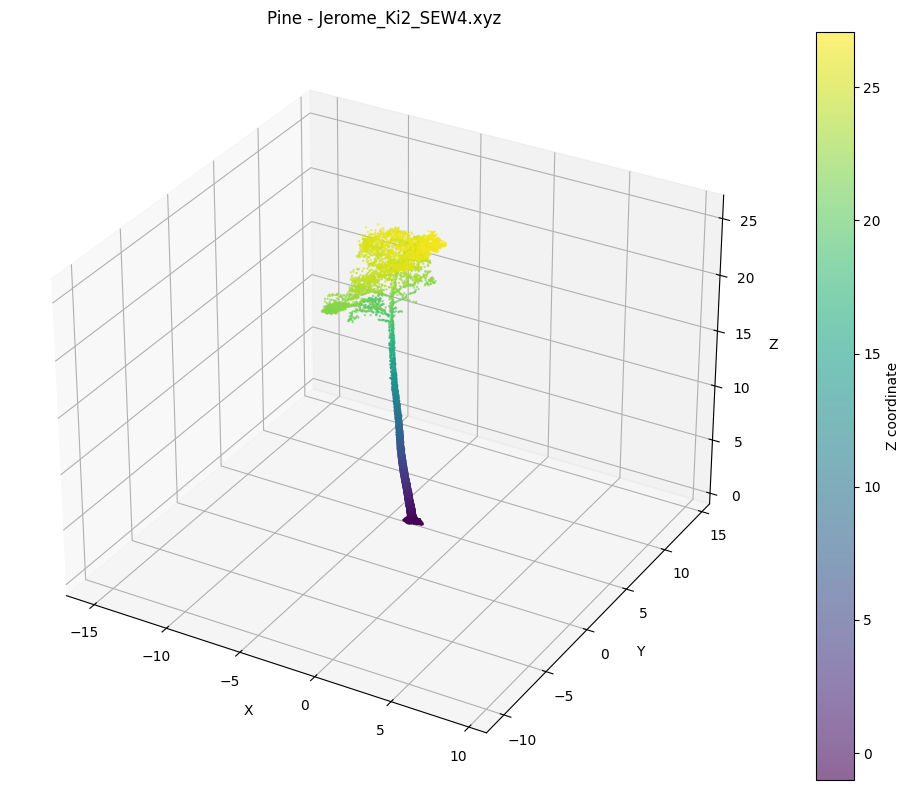


Processing Red Oak...
  File: Baum1_66 nrwl33- Cloud.txt
  Points: 86,251
Downsampled from 86,251 to 10,782 points for visualization


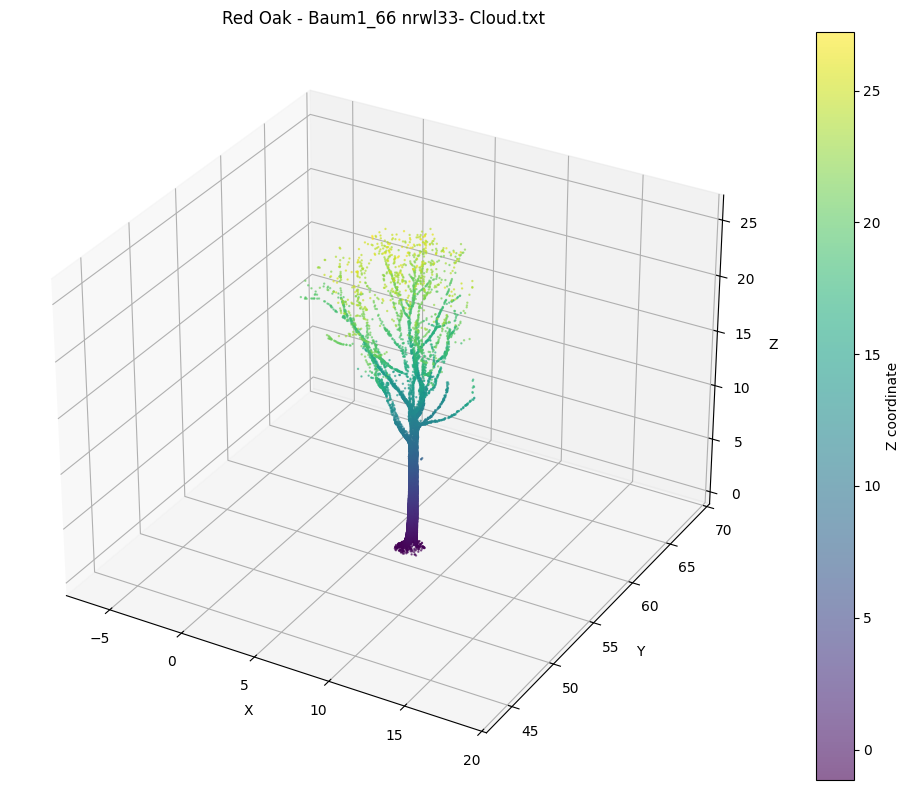


Processing Spruce...
  File: 65_38.txt
  Points: 83,637
Downsampled from 83,637 to 10,455 points for visualization


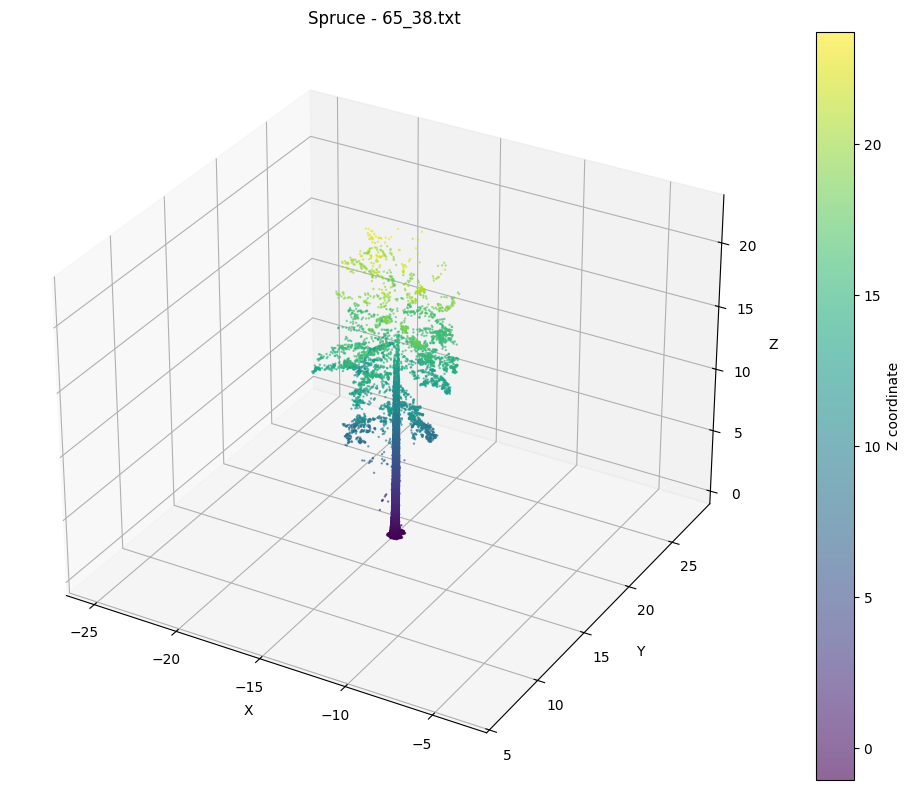


Visualization complete!


In [31]:
# Visualize one sample from each species
print("Loading and visualizing samples from each species...")
print("=" * 60)

for species in sorted(stats['train'].keys()):
    print(f"\nProcessing {species}...")
    
    # Get one sample file
    sample_files = get_sample_files(species, "train", 1)
    
    if sample_files:
        sample_file = sample_files[0]
        points = load_point_cloud(sample_file)
        
        if points is not None:
            print(f"  File: {sample_file.name}")
            print(f"  Points: {len(points):,}")
            
            # Plot the point cloud
            plot_point_cloud(points, f"{species} - {sample_file.name}")
        else:
            print(f"  Failed to load: {sample_file.name}")
    else:
        print(f"  No files found for {species}")

print("\nVisualization complete!")

## 6. Point Cloud Properties Analysis

Analyze basic properties across different species to understand the data characteristics.

In [32]:
# Analyze properties across species
def analyze_point_cloud_properties(points):
    """Analyze basic properties of a point cloud"""
    if points is None or len(points) == 0:
        return None
    
    properties = {
        'num_points': len(points),
        'center': np.mean(points, axis=0),
        'min_bounds': np.min(points, axis=0),
        'max_bounds': np.max(points, axis=0),
        'extents': np.max(points, axis=0) - np.min(points, axis=0),
        'std_dev': np.std(points, axis=0)
    }
    
    # Calculate volume (bounding box)
    properties['bounding_volume'] = np.prod(properties['extents'])
    
    # Point density
    if properties['bounding_volume'] > 0:
        properties['point_density'] = properties['num_points'] / properties['bounding_volume']
    else:
        properties['point_density'] = 0
    
    return properties

# Collect properties for multiple samples per species
print("Analyzing point cloud properties across species...")
print("=" * 80)

species_properties = {}

for species in sorted(stats['train'].keys()):
    print(f"\nAnalyzing {species}...")
    
    # Get multiple samples for better statistics
    sample_files = get_sample_files(species, "train", 3)
    species_props = []
    
    for sample_file in sample_files:
        points = load_point_cloud(sample_file)
        props = analyze_point_cloud_properties(points)
        
        if props:
            species_props.append(props)
            print(f"  {sample_file.name}: {props['num_points']:,} points")
    
    if species_props:
        # Calculate average properties for this species
        avg_props = {}
        for key in ['num_points', 'bounding_volume', 'point_density']:
            values = [p[key] for p in species_props]
            avg_props[key] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values)
            }
        
        species_properties[species] = avg_props

# Display summary table
print(f"\nSummary of Point Cloud Properties")
print("=" * 80)
print(f"{'Species':<15} {'Avg Points':<15} {'Avg Volume':<15} {'Avg Density':<15}")
print("-" * 80)

for species, props in species_properties.items():
    avg_points = props['num_points']['mean']
    avg_volume = props['bounding_volume']['mean']
    avg_density = props['point_density']['mean']
    
    print(f"{species:<15} {avg_points:<15,.0f} {avg_volume:<15,.1f} {avg_density:<15,.2f}")

print("\nKey Observations:")
print("- Point count varies significantly between species")
print("- Density differences may indicate different scanning conditions")
print("- Volume differences reflect tree size variations")
print("\nNext step: Feature extraction (LBP + FPFH) for machine learning")

Analyzing point cloud properties across species...

Analyzing Ash...
  94.pts: 74,760 points
  156.pts: 51,983 points
  181.pts: 138,182 points

Analyzing Beech...
  142.pts: 171,377 points
  57.pts: 121,980 points
  43.pts: 78,832 points

Analyzing Douglas Fir...
  Tree1_Interior.xyz: 803,163 points
  Tree6_Interior.xyz: 927,032 points
  Tree15_Border.xyz: 1,586,162 points

Analyzing Oak...
  29.txt: 245,104 points
  15.txt: 240,851 points
  28.txt: 215,288 points

Analyzing Pine...
  Jerome_Ki2_SEW4.xyz: 270,639 points
  17.txt: 217,928 points
  13.txt: 146,832 points

Analyzing Red Oak...
  Baum1_66 nrwl33- Cloud.txt: 86,251 points
  Baum0_188 nrwl33- Cloud.txt: 78,427 points
  Baum5_350 nrwl33- Cloud.txt: 84,553 points

Analyzing Spruce...
  65_38.txt: 83,637 points
  65_10.txt: 73,635 points
  65_9.txt: 78,156 points

Summary of Point Cloud Properties
Species         Avg Points      Avg Volume      Avg Density    
-------------------------------------------------------------------